## This is my attempt at implementing the RouBl algorithm

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=0.1, init_std=0.1, alpha=0.1, gamma=1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n

        # define and initialise the trainable variational parameters for q distribtuion
        self.mean = nn.Parameter(torch.zeros(n, **factory_kwargs), requires_grad=True)
        self.cov_chol = nn.Parameter(torch.diag(prior_std*torch.ones(n, **factory_kwargs)).detach().clone().requires_grad_(True))

        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ torch.transpose(cov_chol_inv, 0, 1) @ self.mean
        
        # self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_param_std /= self.dim_in ** 0.5
            
        self.prior_std = prior_std

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', torch.zeros(self.num_params, **factory_kwargs))
        self.register_buffer('prior_cov_chol', torch.diag(prior_std*torch.ones(n, **factory_kwargs)))
        self.register_buffer('prior_cov_inv', torch.diag(1/prior_std**2 * torch.ones(n, **factory_kwargs)))

    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    # @property
    # def scale_tril(self):
    #     # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
    #     # Only taking values below the main diagonal? no it takes everything below diagonal
    #     return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_std=0.1, init_std=0.1)
input_data = torch.tensor(([1.0], [1.5]), requires_grad=True)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)


### Regression Ground Truth & Dataset

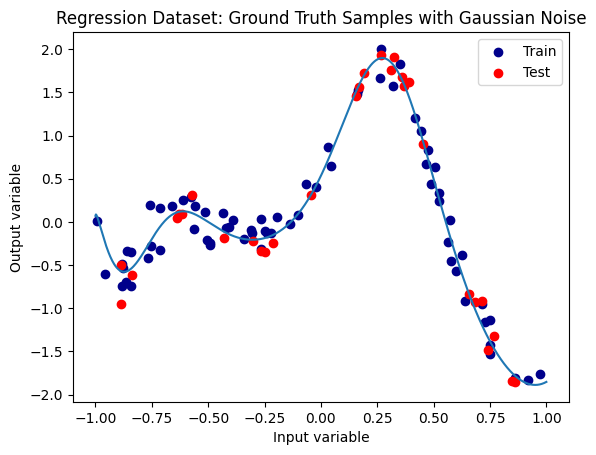

In [3]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Plot BNN Prior in Function Space

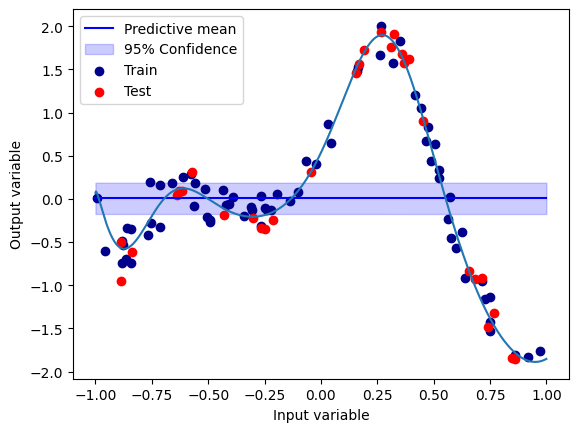

In [4]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=0.1, init_std=0.1, alpha=0.01, gamma=1)

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

### Training

In [17]:
def compute_param_gradients(net, input, targets, sample_std=0.1, K=500):
        gradients = torch.zeros(net.num_params, requires_grad=False)
        for k in range(K):
            sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
            output = net.forward(input, sampled_params)  # Forward pass
            output.backward(torch.ones(output.shape[0]).unsqueeze(1))  # Backpropagate to calculate gradients
            net_grads = sampled_params.grad
            del_log_prior = -net.prior_cov_inv @ (sampled_params - net.prior_mean)
            g_k = -del_log_prior - 1/(sample_std**2) * (targets - output).mean() * net_grads
            gradients += g_k

        return 1/K * gradients.unsqueeze(1)


def compute_pointwise_gradients(net, input_data):
    all_grads = []
    
    # Sample the parameters with requires_grad=True
    sampled_params = net.sample_params()
    
    # Loop over each data point in the input batch
    for i in range(input_data.size(0)):
        input_point = input_data[i:i+1]  # Select a single input point (batch size 1)
        
        # Zero out previous gradients (important to reset before each backward pass)
        if sampled_params.grad is not None:
            sampled_params.grad.zero_()
        
        # Forward pass
        output = net.forward(input_point, sampled_params)
        
        # Backward pass to calculate the gradients for this specific data point
        output.backward(torch.ones_like(output))  # Using 1s to backpropagate for each output
        
        # Store the gradient for this data point
        grads = sampled_params.grad.clone().detach()  # Clone and detach to avoid overwriting
        all_grads.append(grads)
    
    # Stack the gradients into a matrix (rows: data points, columns: weight gradients)
    gradient_matrix = torch.stack(all_grads)
    output = net.forward(input_data, sampled_params)
    return gradient_matrix, output, sampled_params


def compute_g(net, input, targets, std_noise = 0.1, K=500):
        
        gradients = torch.zeros(net.num_params, 1, requires_grad=False)
        for k in range(K):
            net_gradient_matrix, output, sampled_params = compute_pointwise_gradients(net, input)
            del_ll_f = 1/(std_noise**2) * (targets - output) # we haven't assigned noise yet, it is tuneable
            del_ll_w =  net_gradient_matrix.t() @ del_ll_f
            sampled_params = sampled_params.unsqueeze(1)  # Adds a dimension at index 1
            prior_mean = net.prior_mean.unsqueeze(1)
            del_log_prior = - net.prior_cov_inv @ (sampled_params - prior_mean)
            g_k = - del_log_prior - del_ll_w
            gradients += g_k

        print(gradients)
        return 1/K * gradients


# BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=0.1, init_std=0.1, alpha=0.01, gamma=1)
# input_data = torch.tensor(([1.0], [1.5]), requires_grad=True)
# targets = torch.tensor(([2.0], [2.1]), requires_grad=False)

Epoch 1
tensor([[  -57.1086],
        [  -53.8954],
        [  760.5954],
        [  898.7158],
        [-1353.8146],
        [  -29.2652],
        [  -14.9166]], grad_fn=<AddBackward0>)
Epoch 2
tensor([[ 11.5722],
        [  6.4083],
        [-36.9607],
        [-81.7408],
        [ 27.6926],
        [-50.6504],
        [572.5082]], grad_fn=<AddBackward0>)
Epoch 3
tensor([[ -14506.9570],
        [  39576.0625],
        [ 162860.2031],
        [-438430.6875],
        [-327339.1875],
        [-583849.9375],
        [ 414139.0938]], grad_fn=<AddBackward0>)


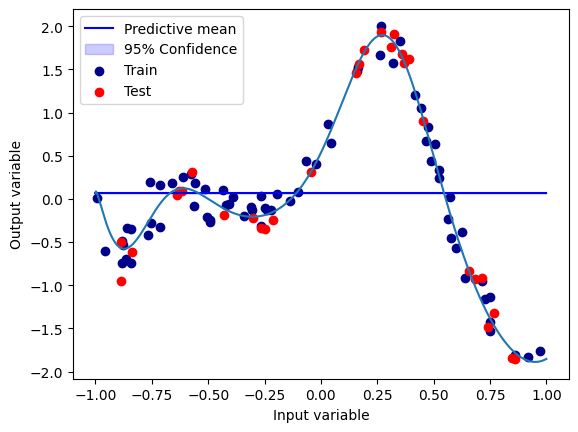

In [18]:
# Using sigma (not its chol), runs into errors computing chol at the end
# def update_variational_params(net, input, targets, sample_std=0.1, K=500):
#     n = net.num_params
#     g = compute_g(net, input, targets, sample_std, K)
#     # g = compute_param_gradients(net, input, targets, sample_std, K)
#     g_tp = g.resize(1, n)

#     with torch.no_grad():
#         mu, sigma = net.mean.unsqueeze(1), net.cov_chol @ net.cov_chol.t()
#         alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        
#         sigma_tilde = 1 / (1 - alpha*gamma) * sigma
#         v = sigma_tilde @ g 
#         sigma = sigma_tilde - alpha / (1 + alpha * g_tp @ v) * v @ v.t()
#         nu = g_tp @ mu
#         lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha * (1 - nu) * g

#     net.lambda_1 = nn.Parameter(lambda_1.flatten(), requires_grad=False)
#     net.mean = nn.Parameter((sigma @ lambda_1).flatten(), requires_grad=False)
#     net.cov_chol = nn.Parameter(torch.linalg.cholesky(sigma, upper=False), requires_grad = False)


# Using rank-1 cholesky update algo
def update_variational_params(net, input, targets, sample_std=1, K=100):
    n = net.num_params
    g = compute_g(net, input, targets, sample_std, K) # I think this is ok but it's possible it's updating in the wrong direction
    # g = compute_param_gradients(net, input, targets, sample_std, K)
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        
        v = alpha_prime * chol @ (chol.t() @ g)

        beta = - alpha / (1 + alpha * g.t() @ v)
        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(alpha_prime * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = alpha_prime * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(alpha_prime) * chol[k,j]
                chol_new[k,j] = torch.sqrt(alpha_prime) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(alpha_prime * chol[j,j]**2)

        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
        
    net.lambda_1 = nn.Parameter(lambda_1.flatten(), requires_grad=False)
    net.mean = nn.Parameter(((chol_new @ chol_new.t())@lambda_1).flatten(), requires_grad=False) # might need to be true
    net.cov_chol = nn.Parameter(chol_new, requires_grad = False) # same here


BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 1], prior_std=1, init_std=0.1, alpha=0.1, gamma=1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 3
sample_std = 0.5

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params(BNN, x_tr, y_tr, sample_std, K=10)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=net, n_samples=1)

# plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)
    


In [9]:
BNN.mean

Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,